In [65]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from causalimpact import CausalImpact
import numpy as np 
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

# Task description
In the collection process of one Mexican bank was implemented a new phone system, which was supposed to improve efficiency of the process. Implementation happened in November 2023. 

You have the following dataset of raw data of all clients, who went to 1st day of delinquency.

- User ID
- Due_date - date of 1st day of delinquency
- Age - age of customer
- Gender - customer gender (1 - F, 2 - M)
- Microcredit - does customer have ever microcredit in the bureau report
- Income - client’s salary
- Overdue_amount - amount of money with which client went to delinquency
- Flg_repaid - does the delinquency was repaid or not (1-repaid, 0 - default of the customer).

**Task is following:**
1. You have to answer the question, does the phone system have an influence on the efficiency of the collection process?
2. If yes - it’s needed to estimate quantitatively the value of influence
3. You need to have good visualisation to explain your result and show it on data. 

# Settings

In [2]:
sns.set_theme()

# Data mining

In [50]:
try:
    cl = pd.read_csv("Case study collection - Sheet1.csv")
except FileNotFoundError:
    cl = pd.read_clipboard()

assert len(cl) == 25000, 'should be 25000 rows'
assert cl['user_id'].count() == 25000, 'should be 25000 total'
cl['due_date'] = pd.to_datetime(cl['due_date'])
cl['week_start'] = cl['due_date'].dt.to_period('W-MON').dt.start_time
cl['month_end'] = cl['due_date'] + pd.offsets.MonthEnd()
cl['group_label'] = (
    'Gender' + cl['gender'].astype(str) +
    '_Micro' + cl['microcredit'].astype(str) +
    '_Repaid' + cl['flg_repaid'].astype(str)
)
cl.head()

,user_id,due_date,age,gender,microcredit,income,overdue_amount,flg_repaid,week_start,month_end,group_label
0,1,2024-09-08,47,0,0,63319.35,1070.6420,1,2024-09-03,2024-09-30,Gender0_Micro0_Repaid1
1,2,2024-02-13,27,1,0,51904.76,755.6342,1,2024-02-13,2024-02-29,Gender1_Micro0_Repaid1
2,3,2020-04-19,65,0,1,26335.22,1040.4410,1,2020-04-14,2020-04-30,Gender0_Micro1_Repaid1
3,4,2023-08-06,61,0,1,41884.76,1365.6820,0,2023-08-01,2023-08-31,Gender0_Micro1_Repaid0
4,5,2020-05-12,28,1,1,28003.69,510.1690,0,2020-05-12,2020-05-31,Gender1_Micro1_Repaid0


# EDA

In [4]:
primary_key = ['user_id']
assert cl.set_index(primary_key).index.is_unique, 'found duplicates'

In [5]:
cl.describe()

,user_id,age,gender,microcredit,income,overdue_amount,flg_repaid
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,12500.500000,45.025240,0.401000,0.690520,36638.425800,1002.102850,0.591280
std,7217.022701,14.746333,0.490111,0.462289,12500.841397,299.203352,0.491607
min,1.000000,20.000000,0.000000,0.000000,10000.000000,100.000000,0.000000
25%,6250.750000,32.000000,0.000000,0.000000,28239.832500,797.511525,0.000000
50%,12500.500000,45.000000,0.000000,1.000000,32723.805000,1001.794500,1.000000
75%,18750.250000,58.000000,1.000000,1.000000,40988.965000,1204.395750,1.000000
max,25000.000000,70.000000,1.000000,1.000000,85249.100000,2150.689000,1.000000


In [6]:
cl['gender'].value_counts(dropna=False)

0    14975
1    10025
Name: gender, dtype: int64

In [7]:
cl['microcredit'].value_counts(dropna=False)

1    17263
0     7737
Name: microcredit, dtype: int64

In [8]:
cl['flg_repaid'].value_counts(dropna=False)

1    14782
0    10218
Name: flg_repaid, dtype: int64

Text(0.5, 0.98, 'User daily counts')

<Figure size 800x500 with 0 Axes>

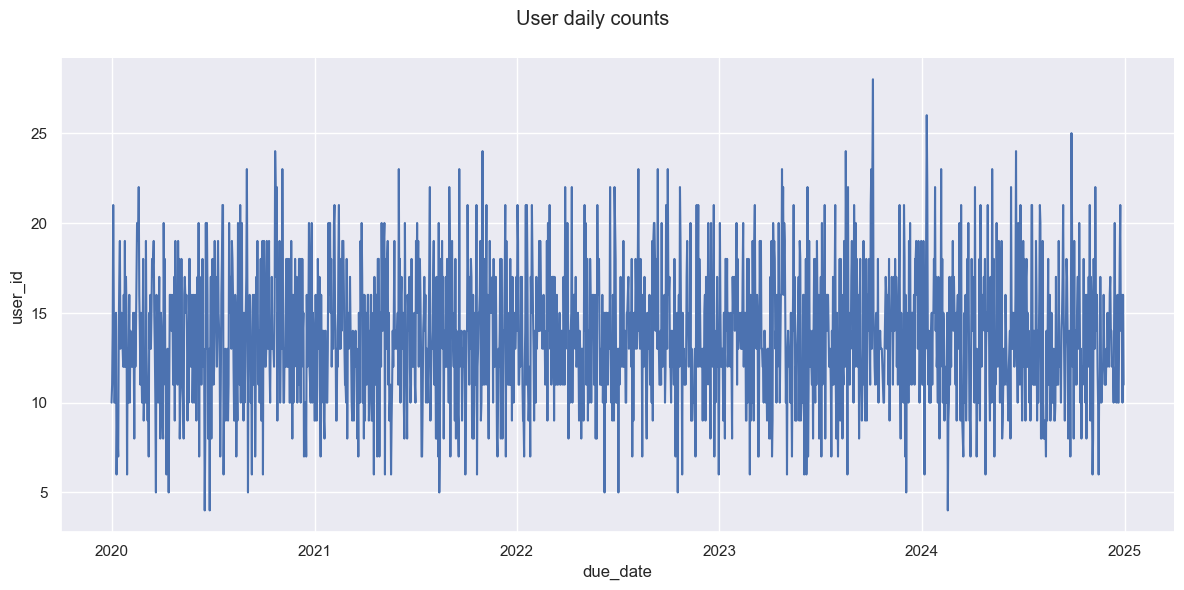

In [37]:
tmp = cl.groupby(['due_date']).agg({'user_id': 'count'}).reset_index()

plt.figure(figsize=(8, 5))

facet = sns.relplot(
    data=tmp,
    x='due_date',
    y='user_id',
    kind='line',
    height=6,
    aspect=2
)

facet.figure.subplots_adjust(top=.9)
facet.figure.suptitle(f'User daily counts')

Text(0.5, 0.98, 'User weekly counts')

<Figure size 1000x600 with 0 Axes>

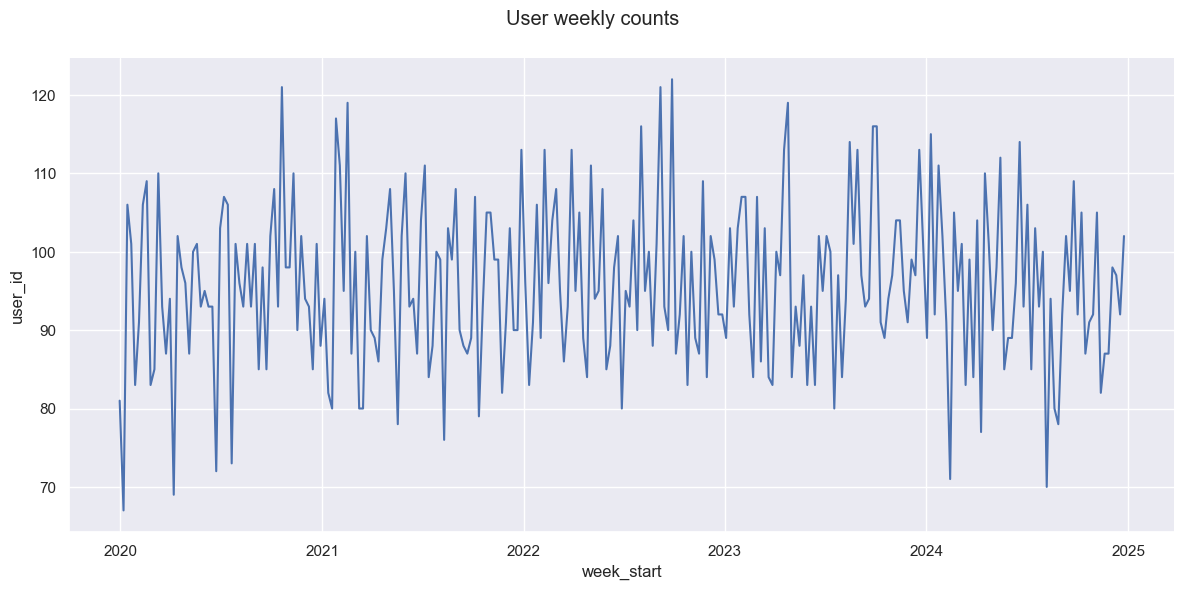

In [38]:
tmp = cl.groupby(['week_start']).agg({'user_id': 'count'}).reset_index()

plt.figure(figsize=(10, 6))

facet = sns.relplot(
    data=tmp,
    x='week_start',
    y='user_id',
    kind='line',
    height=6,
    aspect=2
)

facet.figure.subplots_adjust(top=.9)
facet.figure.suptitle(f'User weekly counts')

Text(0.5, 0.98, 'User monthly counts')

<Figure size 1000x600 with 0 Axes>

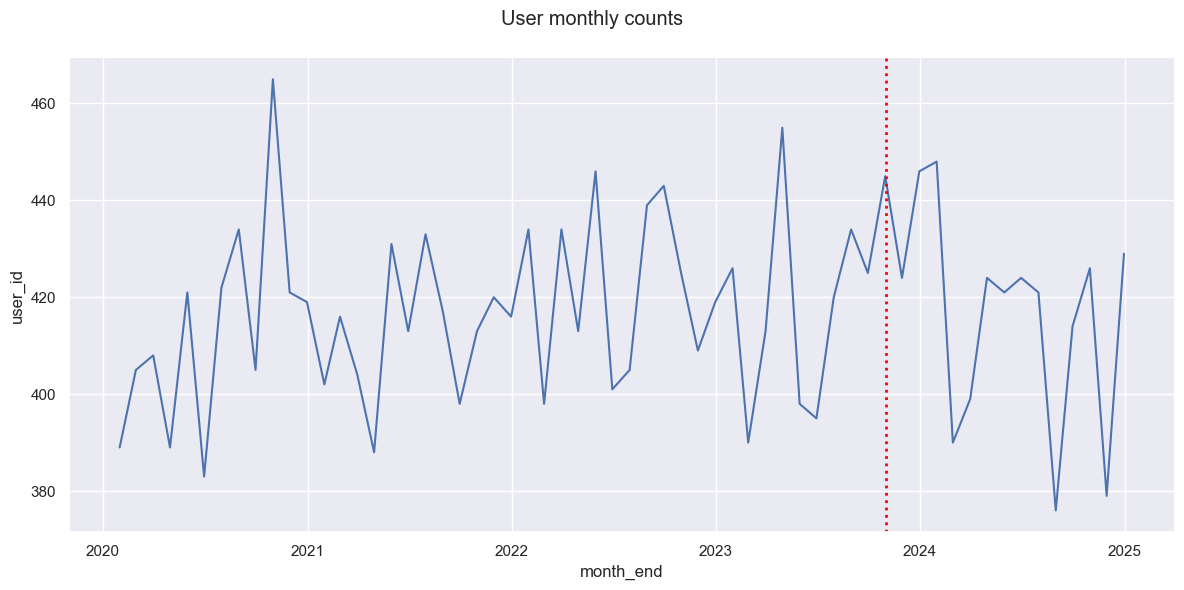

In [41]:
tmp = cl.groupby(['month_end']).agg({'user_id': 'count'}).reset_index()

plt.figure(figsize=(10, 6))

facet = sns.relplot(
    data=tmp,
    x='month_end',
    y='user_id',
    kind='line',
    height=6,
    aspect=2
)

cutoff = pd.to_datetime('2023-11-01')
facet.ax.axvline(cutoff, color='red', linestyle=':', linewidth=2, label='Phone system implemented')

facet.figure.subplots_adjust(top=.9)
facet.figure.suptitle(f'User monthly counts')

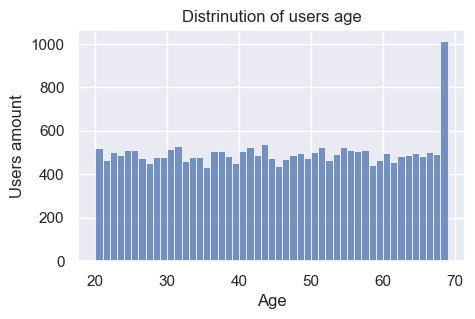

In [12]:
bins = [i for i in range(20, 70)]  

plt.figure(figsize=(5, 3))

sns.histplot(cl['age'], bins=bins, kde=False)

plt.title('Distrinution of users age')
plt.xlabel('Age')
plt.ylabel('Users amount')
plt.show()

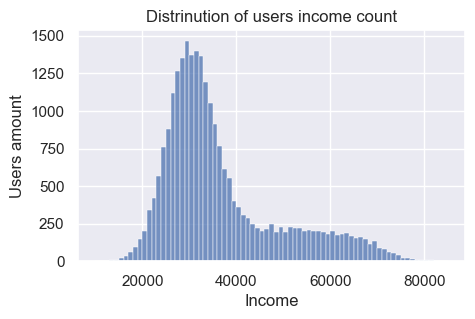

In [13]:
bins = [i for i in range(10000, 85300, 1000)]  

plt.figure(figsize=(5, 3))

sns.histplot(cl['income'], bins=bins, kde=False)

plt.title('Distrinution of users income count')
plt.xlabel('Income')
plt.ylabel('Users amount')
plt.show()


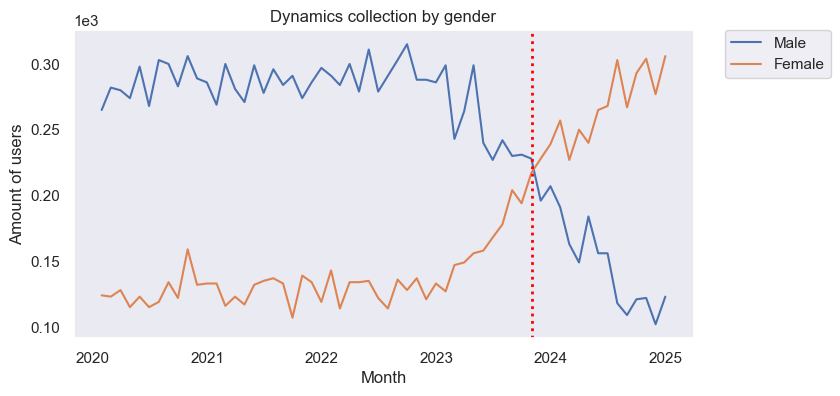

In [85]:
tmp = (
    cl[['month_end', 'gender','user_id']]
    .groupby(['month_end','gender'])
    .agg(count=('user_id', 'count'))
    .reset_index()
)

tmp['gender'][tmp['gender']==1]='Female'
tmp['gender'][tmp['gender']==0]='Male'

X = tmp['month_end']
types = tmp['gender'].unique()  

plt.figure(figsize=(8, 4))

for type in types:
    subset = tmp[tmp['gender'] == type]  
    sns.lineplot(x=subset['month_end'], y=subset['count'], label=f'{type}')  

plt.title('Dynamics collection by gender')
plt.xlabel('Month')
plt.ylabel('Amount of users')

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

cutoff = pd.to_datetime('2023-11-01')
plt.axvline(cutoff, color='red', linestyle=':', linewidth=2, label='Phone system implemented')

plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.grid()
plt.show()

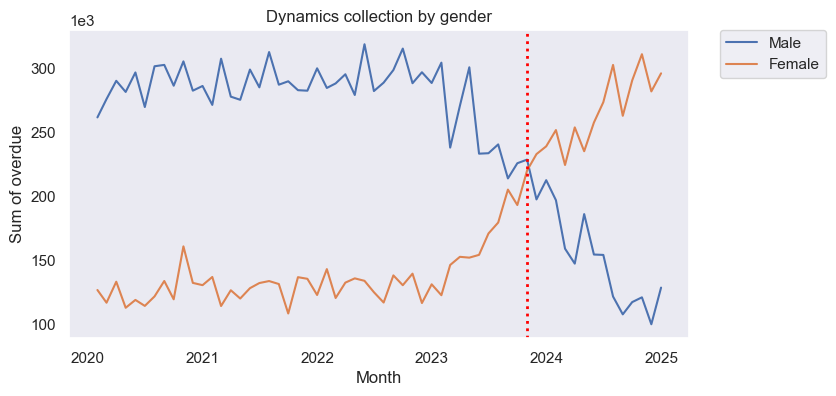

In [83]:
tmp = (
    cl[['month_end', 'gender','overdue_amount']]
    .groupby(['month_end','gender'])
    .agg(sum=('overdue_amount', 'sum'))
    .reset_index()
)

tmp['gender'][tmp['gender']==1]='Female'
tmp['gender'][tmp['gender']==0]='Male'

X = tmp['month_end']
types = tmp['gender'].unique()  

plt.figure(figsize=(8, 4))

for type in types:
    subset = tmp[tmp['gender'] == type]  
    sns.lineplot(x=subset['month_end'], y=subset['sum'], label=f'{type}')  

plt.title('Dynamics collection by gender')
plt.xlabel('Month')
plt.ylabel('Sum of overdue')

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

cutoff = pd.to_datetime('2023-11-01')
plt.axvline(cutoff, color='red', linestyle=':', linewidth=2, label='Phone system implemented')

plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.grid()
plt.show()

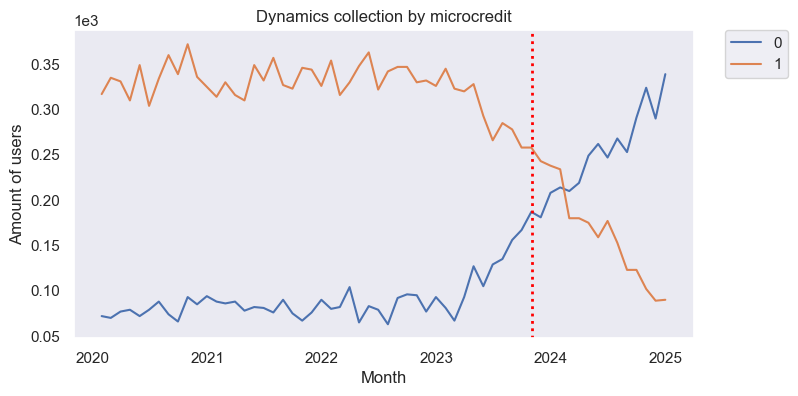

In [86]:
tmp = (
    cl[['month_end', 'microcredit','user_id']]
    .groupby(['month_end','microcredit'])
    .agg(count=('user_id', 'count'))
    .reset_index()
)

X = tmp['month_end']
types = tmp['microcredit'].unique()  

plt.figure(figsize=(8, 4))

for type in types:
    subset = tmp[tmp['microcredit'] == type]  
    sns.lineplot(x=subset['month_end'], y=subset['count'], label=f'{type}')  

plt.title('Dynamics collection by microcredit')
plt.xlabel('Month')
plt.ylabel('Amount of users')

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

cutoff = pd.to_datetime('2023-11-01')
plt.axvline(cutoff, color='red', linestyle=':', linewidth=2, label='Phone system implemented')

plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.grid()
plt.show()

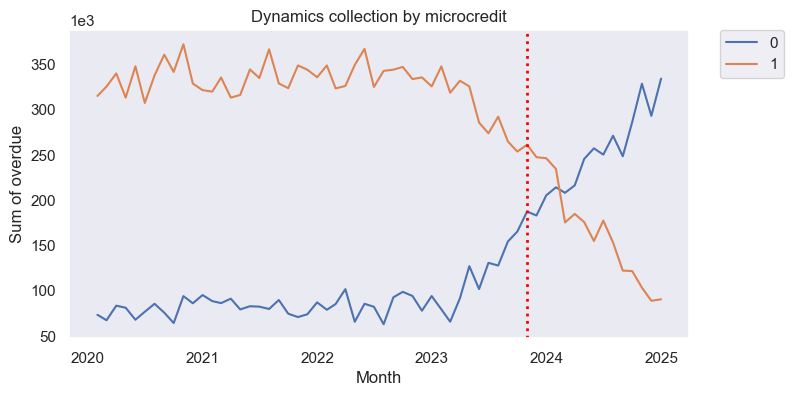

In [47]:
tmp = (
    cl[['month_end', 'microcredit','overdue_amount']]
    .groupby(['month_end','microcredit'])
    .agg(sum=('overdue_amount', 'sum'))
    .reset_index()
)

X = tmp['month_end']
types = tmp['microcredit'].unique()  

plt.figure(figsize=(8, 4))

for type in types:
    subset = tmp[tmp['microcredit'] == type]  
    sns.lineplot(x=subset['month_end'], y=subset['sum'], label=f'{type}')  

plt.title('Dynamics collection by microcredit')
plt.xlabel('Month')
plt.ylabel('Sum of overdue')

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

cutoff = pd.to_datetime('2023-11-01')
plt.axvline(cutoff, color='red', linestyle=':', linewidth=2, label='Phone system implemented')

plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.grid()
plt.show()

In [18]:
cl['age_group'] = pd.cut(cl['age'], bins=range(20, 70, 10), right=False)

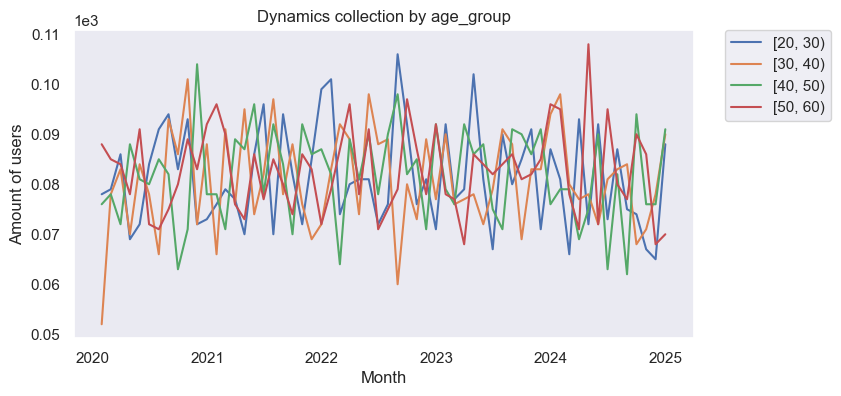

In [19]:
tmp = (
    cl[['month_end', 'age_group','user_id']]
    .groupby(['month_end','age_group'])
    .agg(count=('user_id', 'count'))
    .reset_index()
)

X = tmp['month_end']
types = tmp['age_group'].unique()  

plt.figure(figsize=(8, 4))

for type in types:
    subset = tmp[tmp['age_group'] == type]  
    sns.lineplot(x=subset['month_end'], y=subset['count'], label=f'{type}')  

plt.title('Dynamics collection by age_group')
plt.xlabel('Month')
plt.ylabel('Amount of users')

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.grid()
plt.show()

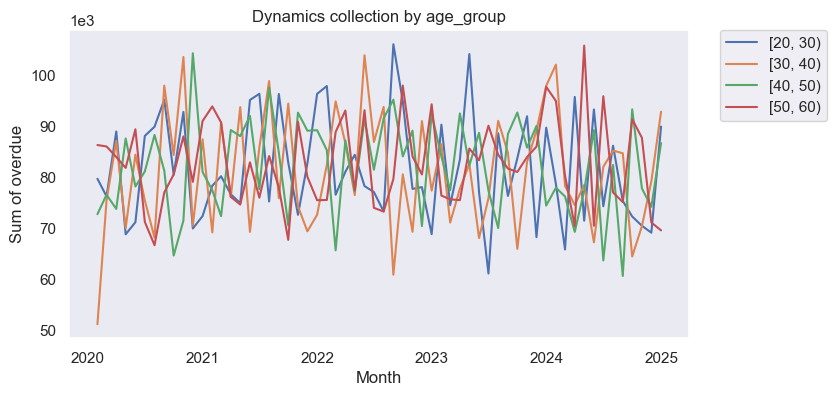

In [20]:
tmp = (
    cl[['month_end', 'age_group','overdue_amount']]
    .groupby(['month_end','age_group'])
    .agg(sum=('overdue_amount', 'sum'))
    .reset_index()
)

X = tmp['month_end']
types = tmp['age_group'].unique()  

plt.figure(figsize=(8, 4))

for type in types:
    subset = tmp[tmp['age_group'] == type]  
    sns.lineplot(x=subset['month_end'], y=subset['sum'], label=f'{type}')  

plt.title('Dynamics collection by age_group')
plt.xlabel('Month')
plt.ylabel('Sum of overdue')

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.grid()
plt.show()

In [57]:
cl['income_group'] = pd.cut(cl['income'], bins=range(10000, 85300, 10000), right=False)

In [59]:
tmp = (
    cl[['month_end', 'income_group', 'user_id']]
    .groupby(['month_end', 'income_group'])
    .agg(count=('user_id', 'count'))
    .reset_index()
)

fig = px.line(
    tmp,
    x='month_end',
    y='count',
    color='income_group',
    title='Dynamics collection by income_group',
    labels={
        'month_end': 'Month',
        'count': 'Amount of users',
        'income_group': 'Income Group'
    },
    line_shape='linear'
)

fig.add_shape(
    type="line",
    x0="2023-11-01", x1="2023-11-01",
    y0=0, y1=1,
    xref='x', yref='paper',
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x="2023-11-01",
    y=1,
    xref="x",
    yref="paper",
    text="Phone system implemented",
    showarrow=False,
    yanchor="bottom",
    font=dict(color="red")
)

fig.update_layout(
    yaxis_tickformat='.1s',
    xaxis_tickangle=-45,
    template='plotly_white',
    legend_title_text='Income Group'
)

fig.show()

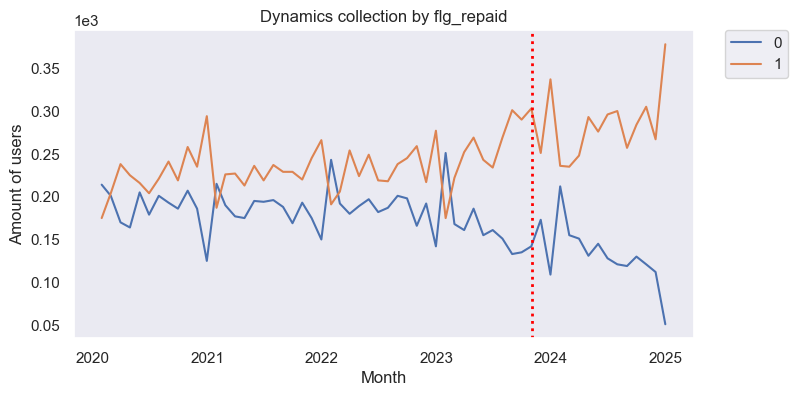

In [48]:
tmp = (
    cl[['month_end', 'flg_repaid','user_id']]
    .groupby(['month_end','flg_repaid'])
    .agg(count=('user_id', 'count'))
    .reset_index()
)

X = tmp['month_end']
types = tmp['flg_repaid'].unique()  

plt.figure(figsize=(8, 4))

for type in types:
    subset = tmp[tmp['flg_repaid'] == type]  
    sns.lineplot(x=subset['month_end'], y=subset['count'], label=f'{type}')  

plt.title('Dynamics collection by flg_repaid')
plt.xlabel('Month')
plt.ylabel('Amount of users')

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

cutoff = pd.to_datetime('2023-11-01')
plt.axvline(cutoff, color='red', linestyle=':', linewidth=2, label='Phone system implemented')

plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.grid()
plt.show()

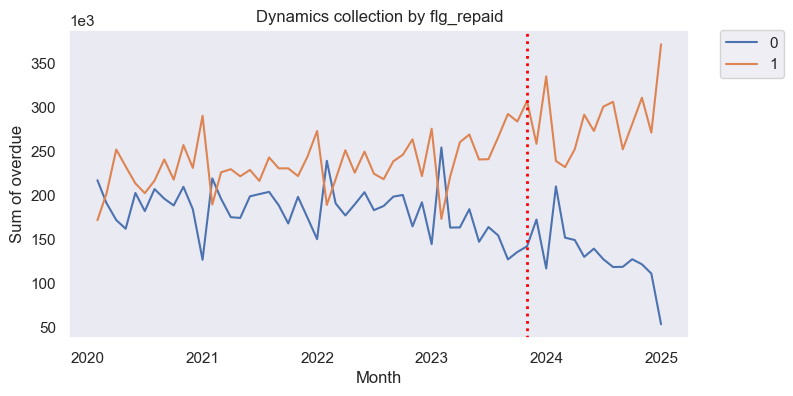

In [49]:
tmp = (
    cl[['month_end', 'flg_repaid','overdue_amount']]
    .groupby(['month_end','flg_repaid'])
    .agg(sum=('overdue_amount', 'sum'))
    .reset_index()
)

X = tmp['month_end']
types = tmp['flg_repaid'].unique()  

plt.figure(figsize=(8, 4))

for type in types:
    subset = tmp[tmp['flg_repaid'] == type]  
    sns.lineplot(x=subset['month_end'], y=subset['sum'], label=f'{type}')  

plt.title('Dynamics collection by flg_repaid')
plt.xlabel('Month')
plt.ylabel('Sum of overdue')

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

cutoff = pd.to_datetime('2023-11-01')
plt.axvline(cutoff, color='red', linestyle=':', linewidth=2, label='Phone system implemented')

plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.grid()
plt.show()

In [ ]:
tmp = (
    cl[['month_end', 'group_label', 'user_id']]
    .groupby(['month_end', 'group_label'])
    .agg(count=('user_id', 'count'))
    .reset_index()
)

fig = px.line(
    tmp,
    x='month_end',
    y='count',
    color='group_label',
    title='Dynamics collection by group_label',
    labels={'month_end': 'Month', 'count': 'Amount of users'},
    line_shape='linear'
)

fig.add_shape(
    type="line",
    x0="2023-11-01", x1="2023-11-01",
    y0=0, y1=1,
    xref='x', yref='paper',
    line=dict(color="red", width=2, dash="dot"),
)

fig.add_annotation(
    x="2023-11-01",
    y=1,
    xref="x",
    yref="paper",
    text="Phone system implemented",
    showarrow=False,
    yanchor="bottom",
    font=dict(color="red")
)

fig.update_layout(
    legend_title_text='Group Label',
    yaxis_tickformat='.1s',
    xaxis_tickangle=-45,
    template='plotly_white'
)

fig.show()

# Experiment

In [26]:
cl.head(3)

,user_id,due_date,age,gender,microcredit,income,overdue_amount,flg_repaid,week_start,month_end,group_label,age_group,income_group
0,1,2024-09-08,47,0,0,63319.35,1070.6420,1,2024-09-03,2024-09-30,G0_M0_R1,"[40.0, 50.0)","[60000, 70000)"
1,2,2024-02-13,27,1,0,51904.76,755.6342,1,2024-02-13,2024-02-29,G1_M0_R1,"[20.0, 30.0)","[50000, 60000)"
2,3,2020-04-19,65,0,1,26335.22,1040.4410,1,2020-04-14,2020-04-30,G0_M1_R1,NaN,"[20000, 30000)"


In [60]:
cl['period'] = cl['month_end'].apply(lambda x: 'before' if x < pd.to_datetime('2023-11-01') else 'after')

collection_rate_period = cl.groupby(['period', 'month_end']).agg(
    total_users=('user_id', 'count'),
    repaid_users=('flg_repaid', 'sum'),
    total_amount=('overdue_amount', 'sum'),
    repaid_amount=('overdue_amount', lambda x: x[cl.loc[x.index, 'flg_repaid'] == 1].sum())
).reset_index()

collection_rate_period['collection_rate_share'] = collection_rate_period['repaid_users'] / collection_rate_period['total_users']
collection_rate_period['collection_rate_amount'] = collection_rate_period['repaid_amount'] / collection_rate_period['total_amount']

collection_plot_period = collection_rate_period.melt(
    id_vars=['month_end', 'period'],
    value_vars=['collection_rate_share', 'collection_rate_amount'],
    var_name='metric',
    value_name='value'
)

In [61]:
fig = px.line(
    collection_plot_period,
    x='month_end',
    y='value',
    color='period',
    line_dash='metric',
    markers=True,
    title='Collection Rate by Month (Before vs After Phone System)',
    labels={
        'month_end': 'Month',
        'value': 'Collection Rate',
        'period': 'Period',
        'metric': 'Metric'
    }
)

fig.update_layout(
    yaxis_tickformat=".0%",
    hovermode="x unified",
    legend_title_text='',
    template="plotly_white"
)

fig.show()

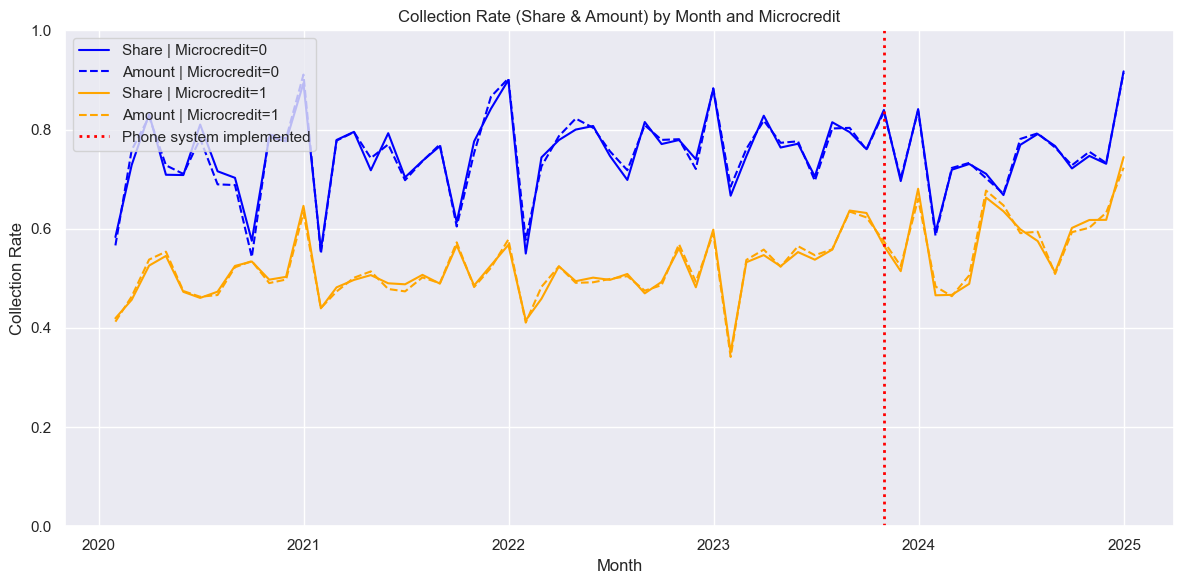

In [62]:
collection_rate_micro = cl.groupby(['month_end', 'microcredit']).agg(
    total_users=('user_id', 'count'),
    repaid_users=('flg_repaid', 'sum'),
    total_amount=('overdue_amount', 'sum'),
    repaid_amount=('overdue_amount', lambda x: x[cl.loc[x.index, 'flg_repaid'] == 1].sum())
).reset_index()

collection_rate_micro['collection_rate_share'] = collection_rate_micro['repaid_users'] / collection_rate_micro['total_users']
collection_rate_micro['collection_rate_amount'] = collection_rate_micro['repaid_amount'] / collection_rate_micro['total_amount']

fig, ax = plt.subplots(figsize=(12, 6))

colors = {0: 'blue', 1: 'orange'}

for mc in [0, 1]:
    df = collection_rate_micro[collection_rate_micro['microcredit'] == mc]
    ax.plot(df['month_end'], df['collection_rate_share'], label=f'Share | Microcredit={mc}', color=colors[mc], linestyle='-')
    ax.plot(df['month_end'], df['collection_rate_amount'], label=f'Amount | Microcredit={mc}', color=colors[mc], linestyle='--')

cutoff = pd.to_datetime('2023-11-01')
ax.axvline(cutoff, color='red', linestyle=':', linewidth=2, label='Phone system implemented')

ax.set_title('Collection Rate (Share & Amount) by Month and Microcredit')
ax.set_xlabel('Month')
ax.set_ylabel('Collection Rate')
ax.legend(loc='upper left')
ax.grid(True)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

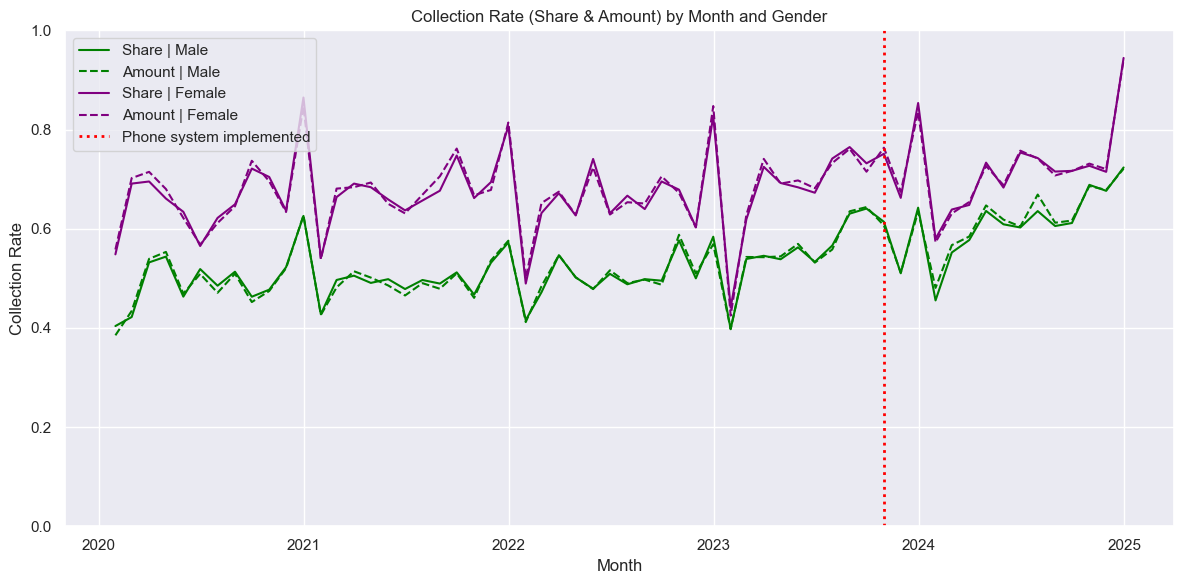

In [ ]:
collection_rate_gender = cl.groupby(['month_end', 'gender']).agg(
    total_users=('user_id', 'count'),
    repaid_users=('flg_repaid', 'sum'),
    total_amount=('overdue_amount', 'sum'),
    repaid_amount=('overdue_amount', lambda x: x[cl.loc[x.index, 'flg_repaid'] == 1].sum())
).reset_index()

collection_rate_gender['collection_rate_share'] = collection_rate_gender['repaid_users'] / collection_rate_gender['total_users']
collection_rate_gender['collection_rate_amount'] = collection_rate_gender['repaid_amount'] / collection_rate_gender['total_amount']

fig, ax = plt.subplots(figsize=(12, 6))

colors = {0: 'green', 1: 'purple'}  # 0 = Male, 1 = Female

for g in [0, 1]:
    df = collection_rate_gender[collection_rate_gender['gender'] == g]
    label_prefix = 'Male' if g == 0 else 'Female'
    ax.plot(df['month_end'], df['collection_rate_share'], label=f'Share | {label_prefix}', color=colors[g], linestyle='-')
    ax.plot(df['month_end'], df['collection_rate_amount'], label=f'Amount | {label_prefix}', color=colors[g], linestyle='--')

cutoff = pd.to_datetime('2023-11-01')
ax.axvline(cutoff, color='red', linestyle=':', linewidth=2, label='Phone system implemented')

ax.set_title('Collection Rate (Share & Amount) by Month and Gender')
ax.set_xlabel('Month')
ax.set_ylabel('Collection Rate')
ax.legend(loc='upper left')
ax.grid(True)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
cl['month_end'] = pd.to_datetime(cl['month_end'])
cl['age_group'] = pd.cut(cl['age'], bins=[0, 30, 45, 60, 100], labels=["<30", "30-45", "45-60", "60+"])

collection_rate_age = cl.groupby(['month_end', 'age_group']).agg(
    total_users=('user_id', 'count'),
    repaid_users=('flg_repaid', 'sum'),
    total_amount=('overdue_amount', 'sum'),
    repaid_amount=('overdue_amount', lambda x: x[cl.loc[x.index, 'flg_repaid'] == 1].sum())
).reset_index()

collection_rate_age['collection_rate_share'] = collection_rate_age['repaid_users'] / collection_rate_age['total_users']
collection_rate_age['collection_rate_amount'] = collection_rate_age['repaid_amount'] / collection_rate_age['total_amount']

plot_df_melted = collection_rate_age.melt(
    id_vars=['month_end', 'age_group'],
    value_vars=['collection_rate_share', 'collection_rate_amount'],
    var_name='metric',
    value_name='value'
)

plot_df_melted['metric'] = plot_df_melted['metric'].map({
    'collection_rate_share': 'Share (шт.)',
    'collection_rate_amount': 'Amount (сумма)'
})

fig = px.line(
    plot_df_melted,
    x='month_end',
    y='value',
    color='age_group',
    line_dash='metric',
    title='Collection Rate by Month and Age Group (Interactive)',
    labels={
        'value': 'Collection Rate',
        'month_end': 'Month',
        'age_group': 'Age Group',
        'metric': 'Metric'
    }
)

fig.add_shape(
    type="line",
    x0="2023-11-01", x1="2023-11-01",
    y0=0, y1=1,
    xref='x', yref='paper',
    line=dict(color="red", width=2, dash="dot"),
)

fig.add_annotation(
    x="2023-11-01",
    y=1,
    xref="x",
    yref="paper",
    text="Phone system implemented",
    showarrow=False,
    yanchor="bottom",
    font=dict(color="red")
)

fig.update_layout(legend_title_text='Age Group & Metric')
fig.show()

In [64]:
cl['month_end'] = pd.to_datetime(cl['month_end'])

monthly_cr = cl.groupby('month_end').agg(
    collection_rate_amount=(
        'overdue_amount',
        lambda x: x[cl.loc[x.index, 'flg_repaid'] == 1].sum() / x.sum()
    ),
    avg_age=('age', 'mean'),
    avg_income=('income', 'mean'),
    avg_gender=('gender', 'mean'),  # 1 = F, 2 = M
    microcredit_rate=('microcredit', 'mean')
).sort_index()

monthly_cr['post'] = (monthly_cr.index >= pd.to_datetime("2023-11-01")).astype(int)

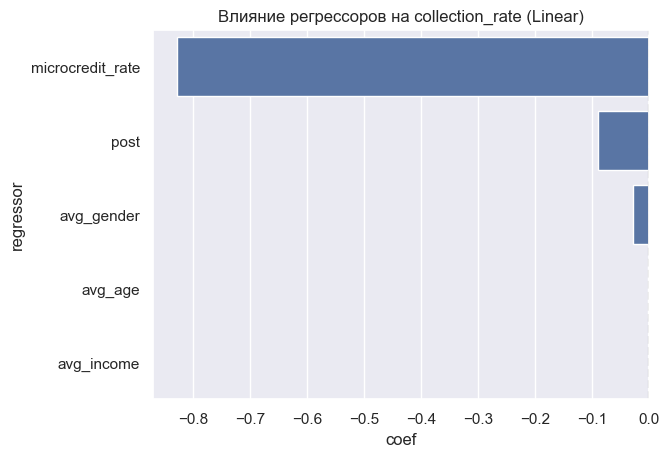

In [ ]:
monthly_cr['post'] = (monthly_cr.index >= pd.to_datetime("2023-11-01")).astype(int)

X = monthly_cr[['avg_age', 'avg_income', 'avg_gender', 'microcredit_rate', 'post']]
y = monthly_cr['collection_rate_amount']

model = LinearRegression()
model.fit(X, y)

coeffs = pd.DataFrame({
    'regressor': X.columns,
    'coef': model.coef_
}).sort_values(by='coef', key=abs, ascending=False)

sns.barplot(data=coeffs, x='coef', y='regressor')
plt.title("Влияние регрессоров на collection_rate (Linear)")
plt.axvline(0, color='grey', linestyle='--')
plt.show()

                               Average      Cumulative
Actual                               0               9
Predicted                            0              10
95% CI                          [0, 0]         [9, 11]
                                                      
Absolute Effect                      0              -1
95% CI                          [0, 0]         [0, -2]
                                                      
Relative Effect                 -10.1%          -10.1%
95% CI                  [2.4%, -22.6%]  [2.4%, -22.6%]
                                                      
P-value                           0.0%                
Prob. of Causal Effect          100.0%                
None
During the post-intervention period, the response             variable had an average value of             approx. 0.
By contrast, in  the absence of an intervention, we would have expected an average response of 0. The 95% interval of
this counterfactual prediction is [0, 0]. Su

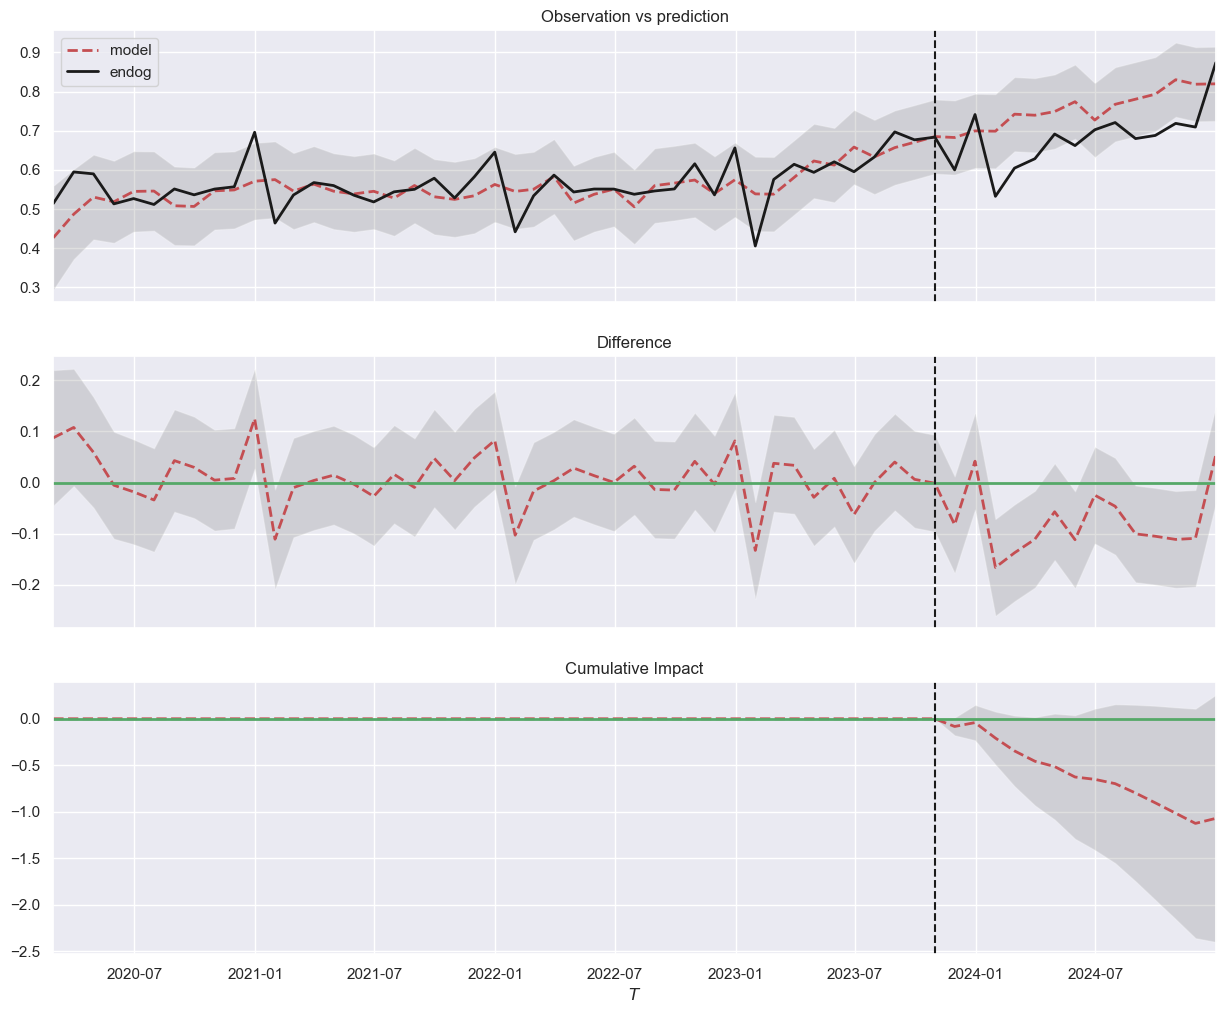

In [ ]:
cl['month_end'] = pd.to_datetime(cl['month_end'])

monthly_cr = cl.groupby('month_end').agg(
    collection_rate_amount=(
        'overdue_amount',
        lambda x: x[cl.loc[x.index, 'flg_repaid'] == 1].sum() / x.sum()
    ),
    avg_age=('age', 'mean'),
    avg_income=('income', 'mean'),
    avg_gender=('gender', 'mean'),  # 0 = M, 1 = F
    microcredit_rate=('microcredit', 'mean')  
).reset_index()

monthly_cr = monthly_cr.sort_values('month_end')
monthly_cr.set_index('month_end', inplace=True)
monthly_cr = monthly_cr.asfreq('M')

pre_period = [monthly_cr.index.min(), pd.to_datetime("2023-10-31")]
post_period = [pd.to_datetime("2023-11-30"), monthly_cr.index.max()]

ci = CausalImpact(monthly_cr, pre_period, post_period)
ci.run()

print(ci.summary())
print(ci.summary(output='report'))
ci.plot()

In [82]:
print(f"Фактическая сумма погашений: {cl['overdue_amount'][(cl['month_end'] >= pd.to_datetime('2023-11-30')) & (cl['flg_repaid'] == 1)].sum():,.2f}")
print(f"Прогноз по модели (без внедрения): {cl['overdue_amount'][(cl['month_end'] >= pd.to_datetime('2023-11-30')) & (cl['flg_repaid'] == 1)].sum()*(1-0.101):,.2f}")
print(f"Абсолютный эффект: {cl['overdue_amount'][(cl['month_end'] >= pd.to_datetime('2023-11-30')) & (cl['flg_repaid'] == 1)].sum()-cl['overdue_amount'][(cl['month_end'] >= pd.to_datetime('2023-11-30')) & (cl['flg_repaid'] == 1)].sum()*(1-0.101):,.2f}")

Фактическая сумма погашений: 3,970,608.84
Прогноз по модели (без внедрения): 3,569,577.35
Абсолютный эффект: 401,031.49
